#                                                           Amazon Reviews using Spark and Python

**OBJECTIF :** 

L'objectif de ce projet est de créer un modèle capable de prédire la note attribuée à une revue sur Amazon à partir du texte de la revue elle-même. En utilisant les données disponibles dans la base de données "CDs and vinyl" d'Amazon, le projet vise à entraîner un modèle d'apprentissage automatique qui peut apprendre à associer le contenu du texte de la revue à la note attribuée par le critique. Une fois le modèle entraîné, il peut être utilisé pour prédire les notes des revues futures sur la base du texte de la revue.

**DATA DESCRIPTION :**

- **asin :** C'est un identifiant unique pour chaque produit dans la base de données d'Amazon. Il peut être utilisé pour faire référence à un produit spécifique lors de l'analyse des avis et des revues.

- **helpful :** Cette colonne représente le nombre de personnes qui ont trouvé l'avis utile par rapport au nombre total de personnes ayant voté sur l'utilité de l'avis. La valeur est généralement représentée sous la forme d'une paire de nombres, par exemple, "2/3" indique que 2 personnes ont trouvé l'avis utile sur un total de 3 votes.

- **overall :** C'est la note globale attribuée au produit par le critique. Elle est généralement exprimée sur une échelle discrète, par exemple, de 1 à 5 étoiles, où 1 est la note la plus basse et 5 est la note la plus élevée.

- **reviewText :** Cette colonne contient le texte complet de la revue rédigée par le critique. Il s'agit de l'opinion détaillée du critique sur le produit.

- **reviewTime :** Cette colonne représente la date à laquelle la revue a été écrite par le critique. Elle est généralement au format texte et peut nécessiter une conversion en un format de date approprié pour l'analyse.

- **reviewerID :** C'est un identifiant unique pour chaque critique dans la base de données d'Amazon. Il peut être utilisé pour suivre les avis et les activités d'un critique particulier.

- **reviewerName :** Il s'agit du nom ou du pseudonyme du critique qui a rédigé la revue. Cela peut aider à identifier ou à faire référence à un critique spécifique.

- **summary :** Cette colonne contient un résumé ou un titre succinct de la revue. Il donne une idée générale du contenu de la revue.

- **unixReviewTime :** C'est le temps de la revue en format de temps

## Import libraries

In [0]:
import pandas as pd
import nltk
import pyspark
from pyspark.sql.functions import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import regexp_replace, trim, col
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator,RankingEvaluator
from pyspark.ml.feature import Word2Vec
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier

In [0]:
pip install pyspark

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 881.9 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 kB 28.9 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317131 sha256=ae01910111380915e81166e29611849f3beeae303c3d7971a47a8ff1f3b8581d
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


Spark Session :

Dans PySpark, la session Spark est créée en utilisant la classe `SparkSession`.

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

###Reading the data

In [0]:
data = spark.read.json("/FileStore/tables/projet1Spark-1.004")

In [0]:
data.show()

+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|      asin| helpful|overall|          reviewText| reviewTime|    reviewerID|        reviewerName|             summary|unixReviewTime|
+----------+--------+-------+--------------------+-----------+--------------+--------------------+--------------------+--------------+
|B000MR9ESK|  [0, 0]|    4.0|I saw Fela on Bro...|07 24, 2010| A8ZX6NLEFPJUW|             drewkaz|          Great Band|    1279929600|
|B000MR9ESK|  [0, 0]|    5.0|Antibalas deliver...|09 23, 2008|A29313797NGT9L|      Eddie Wannabee|      The Real Deal!|    1222128000|
|B000MR9ESK|  [4, 4]|    5.0|A very funky, hip...|07 28, 2008|A1DA8VOH9NR6C7|       E. Minkovitch|Great retro groov...|    1217203200|
|B000MR9ESK|  [7, 7]|    4.0|As one of the bes...|03 27, 2007|A26TWY9AD935HC|        S. Finefrock|Inching out of Fe...|    1174953600|
|B000MR9ESK|  [0, 0]|    5.0|Your cant get any...|12 12

In [0]:
type(data)

pyspark.sql.dataframe.DataFrame

#### Removing uncessary columns from the dataset

In [0]:
columns_to_remove = ["asin", "reviewTime", "reviewerID", "reviewerName", "unixReviewTime"]
data = data.drop(*columns_to_remove)

In [0]:
data.show()

+--------+-------+--------------------+--------------------+
| helpful|overall|          reviewText|             summary|
+--------+-------+--------------------+--------------------+
|  [0, 0]|    4.0|I saw Fela on Bro...|          Great Band|
|  [0, 0]|    5.0|Antibalas deliver...|      The Real Deal!|
|  [4, 4]|    5.0|A very funky, hip...|Great retro groov...|
|  [7, 7]|    4.0|As one of the bes...|Inching out of Fe...|
|  [0, 0]|    5.0|Your cant get any...|Antibalas does it...|
|[27, 35]|    4.0|It takes balls to...|FOUR KINGS - FOUR...|
|  [2, 2]|    4.0|I saw the Kings o...|The Kings' latest...|
|  [1, 1]|    4.0|As far as the sou...|  Bought it on Vinyl|
|  [0, 0]|    3.0|Straight from the...|3-1/2 stars -- Fo...|
| [3, 11]|    2.0|Plainly stated: i...|Experiments are f...|
|  [0, 0]|    5.0|I agree with the ...|DENSE, INTENSE, J...|
|  [0, 0]|    5.0|Great band with a...|          Great band|
|  [2, 4]|    5.0|The first track o...|One of the best o...|
|  [0, 0]|    5.0|I thou

In [0]:
data = data.select("reviewText", "summary", "overall", "helpful")
data.show()

+--------------------+--------------------+-------+--------+
|          reviewText|             summary|overall| helpful|
+--------------------+--------------------+-------+--------+
|I saw Fela on Bro...|          Great Band|    4.0|  [0, 0]|
|Antibalas deliver...|      The Real Deal!|    5.0|  [0, 0]|
|A very funky, hip...|Great retro groov...|    5.0|  [4, 4]|
|As one of the bes...|Inching out of Fe...|    4.0|  [7, 7]|
|Your cant get any...|Antibalas does it...|    5.0|  [0, 0]|
|It takes balls to...|FOUR KINGS - FOUR...|    4.0|[27, 35]|
|I saw the Kings o...|The Kings' latest...|    4.0|  [2, 2]|
|As far as the sou...|  Bought it on Vinyl|    4.0|  [1, 1]|
|Straight from the...|3-1/2 stars -- Fo...|    3.0|  [0, 0]|
|Plainly stated: i...|Experiments are f...|    2.0| [3, 11]|
|I agree with the ...|DENSE, INTENSE, J...|    5.0|  [0, 0]|
|Great band with a...|          Great band|    5.0|  [0, 0]|
|The first track o...|One of the best o...|    5.0|  [2, 4]|
|I thought Youth a...|Do

#### Data Preprocessing

###### Text Cleaning

In [0]:
from pyspark.sql.functions import lower, regexp_replace

data = data.withColumn("reviewText", lower(regexp_replace("reviewText", "[^a-zA-Z0-9\\s]", "")))


#####Tokenization

In [0]:
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol="reviewText", outputCol="reviewText_tokens")
data = tokenizer.transform(data)


##### Removing Stop Words

In [0]:
from pyspark.ml.feature import StopWordsRemover

remover = StopWordsRemover(inputCol="reviewText_tokens", outputCol="reviewText_filtered")
data = remover.transform(data)


In [0]:
data.show()

+--------------------+--------------------+-------+--------+--------------------+--------------------+
|          reviewText|             summary|overall| helpful|   reviewText_tokens| reviewText_filtered|
+--------------------+--------------------+-------+--------+--------------------+--------------------+
|i saw fela on bro...|          Great Band|    4.0|  [0, 0]|[i, saw, fela, on...|[saw, fela, broad...|
|antibalas deliver...|      The Real Deal!|    5.0|  [0, 0]|[antibalas, deliv...|[antibalas, deliv...|
|a very funky hip ...|Great retro groov...|    5.0|  [4, 4]|[a, very, funky, ...|[funky, hip, albu...|
|as one of the bes...|Inching out of Fe...|    4.0|  [7, 7]|[as, one, of, the...|[one, best, fela,...|
|your cant get any...|Antibalas does it...|    5.0|  [0, 0]|[your, cant, get,...|[cant, get, bette...|
|it takes balls to...|FOUR KINGS - FOUR...|    4.0|[27, 35]|[it, takes, balls...|[takes, balls, st...|
|i saw the kings o...|The Kings' latest...|    4.0|  [2, 2]|[i, saw, the,

##### Word embeddings

In [0]:
from pyspark.ml.feature import Word2Vec

word2Vec = Word2Vec(vectorSize=100, inputCol="reviewText_filtered", outputCol="word2vec_features")
model = word2Vec.fit(data)
result = model.transform(data)


In [0]:
data = result
data.show()

+--------------------+--------------------+-------+--------+--------------------+--------------------+--------------------+
|          reviewText|             summary|overall| helpful|   reviewText_tokens| reviewText_filtered|   word2vec_features|
+--------------------+--------------------+-------+--------+--------------------+--------------------+--------------------+
|i saw fela on bro...|          Great Band|    4.0|  [0, 0]|[i, saw, fela, on...|[saw, fela, broad...|[0.02940325200557...|
|antibalas deliver...|      The Real Deal!|    5.0|  [0, 0]|[antibalas, deliv...|[antibalas, deliv...|[-0.1296036727726...|
|a very funky hip ...|Great retro groov...|    5.0|  [4, 4]|[a, very, funky, ...|[funky, hip, albu...|[-0.0090371120288...|
|as one of the bes...|Inching out of Fe...|    4.0|  [7, 7]|[as, one, of, the...|[one, best, fela,...|[-0.0294091143137...|
|your cant get any...|Antibalas does it...|    5.0|  [0, 0]|[your, cant, get,...|[cant, get, bette...|[0.03810173487695...|
|it take

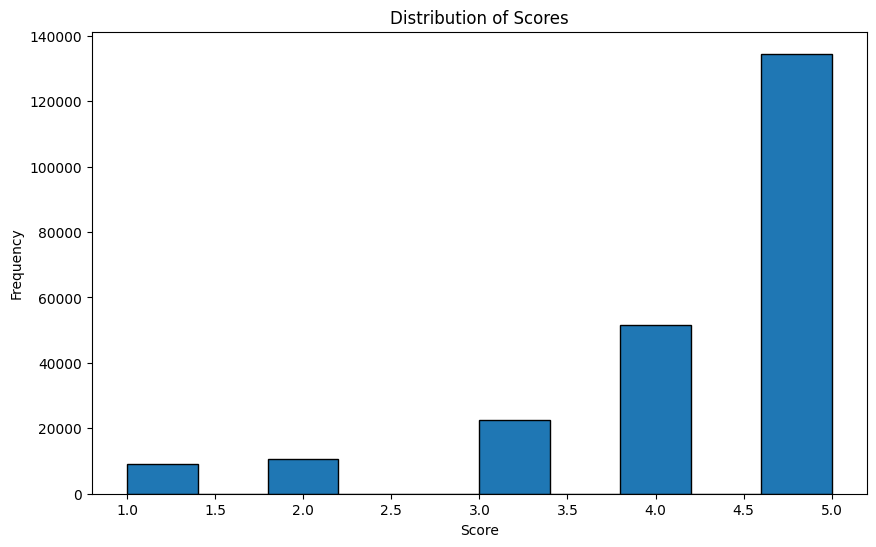

In [0]:
import matplotlib.pyplot as plt

# Extract the scores from the "overall" column
scores = data.select("overall").rdd.flatMap(lambda x: x).collect()

# Plot the distribution of scores
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=10, edgecolor='black')
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.title("Distribution of Scores")
plt.show()


##### Splitting the data into training and testing sets

In [0]:
(train_Data, test_Data) = data.randomSplit([0.8, 0.2], seed=100)


In [0]:
train_Data.show()

+--------------------+--------------------+-------+----------+--------------------+--------------------+--------------------+
|          reviewText|             summary|overall|   helpful|   reviewText_tokens| reviewText_filtered|   word2vec_features|
+--------------------+--------------------+-------+----------+--------------------+--------------------+--------------------+
|    but this aint...|NO ONE DOES FATS ...|    4.0|    [1, 1]|[, , , , but, thi...|[, , , , aint, ba...|[-0.2609161154056...|
|   and im not jus...|Kanye's most colo...|    4.0|    [2, 3]|[, , , and, im, n...|[, , , im, referi...|[-0.0388846930208...|
|   but now i love...|I've always like ...|    5.0|    [2, 4]|[, , , but, now, ...|[, , , love, rush...|[-0.0086248837649...|
|   hardly like a ...|He looks so healt...|    5.0|[120, 124]|[, , , hardly, li...|[, , , hardly, li...|[-0.0109512416476...|
|   is the name of...|Young Man's Fancy...|    5.0|    [3, 3]|[, , , is, the, n...|[, , , name, favo...|[0.02904524522

In [0]:
test_Data.show()

+--------------------+--------------------+-------+--------+--------------------+--------------------+--------------------+
|          reviewText|             summary|overall| helpful|   reviewText_tokens| reviewText_filtered|   word2vec_features|
+--------------------+--------------------+-------+--------+--------------------+--------------------+--------------------+
|   for showing ho...|I thank God for T...|    5.0|  [0, 0]|[, , , for, showi...|[, , , showing, c...|[0.01923271851731...|
| a truly magical ...|A Truly Magical M...|    5.0|  [5, 8]|[, a, truly, magi...|[, truly, magical...|[0.02233356628709...|
| and im not talki...|A good record but...|    4.0|  [1, 1]|[, and, im, not, ...|[, im, talking, g...|[-0.0333465260412...|
| but her material...|I love Lil' Mo, a...|    3.0|  [2, 2]|[, but, her, mate...|[, material, neve...|[-0.0295757935599...|
| following on the...|Multiple Award Wi...|    5.0|  [1, 1]|[, following, on,...|[, following, hea...|[-0.0459520104946...|
| is dre

# Model training

## Logistic Regression

##### Create an instance of the logistic regression model
##### Fit the logistic regression model on the training data

In [0]:
lr = LogisticRegression(featuresCol="word2vec_features", labelCol="overall")
lr_model = lr.fit(train_Data)

##### Make predictions on the test data using the logistic regression model

In [0]:
predictions = lr_model.transform(test_Data)

In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="overall", 
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))



Accuracy: 63.22%


## Random Forest

##### Create en instance of the Random forest model
##### Fit the Random forest model on the training data

In [0]:
rf = RandomForestClassifier(featuresCol="word2vec_features", labelCol="overall")
rf_model = rf.fit(train_Data)


##### Make predictions on the test data using the random forest model

In [0]:
rf_predictions = rf_model.transform(test_Data)


In [0]:
evaluator = MulticlassClassificationEvaluator(labelCol="overall", 
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy = evaluator.evaluate(rf_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))


Accuracy: 59.00%
